# Day x
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, SWA renwal test

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
#os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3468899808721829033
]


## Options

In [3]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [5]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.442s 


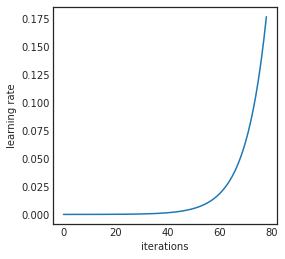

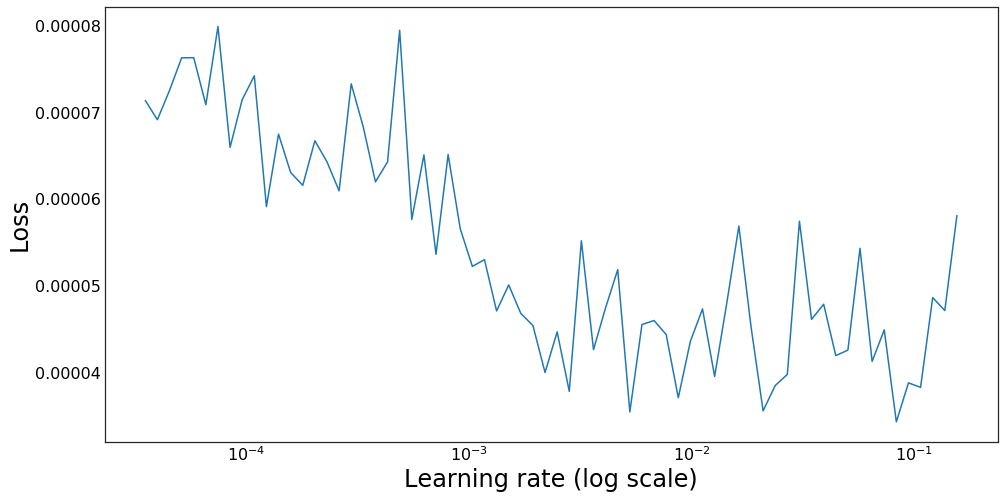

______________________________________



In [6]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,2e-1], trainOnWeights=True, verbose=0)

In [23]:
compileArgs['lr'] = 1e-3

In [24]:
def _batchTrainClassifier(batchYielder, nSplits, modelGen, modelGenParams, trainParams,
                         cosAnnealMult=0, reverseAnneal=False, plotLR=False, reduxDecay=False,
                         annealMomentum=False, reverseAnnealMomentum=False, plotMomentum=False,
                         oneCycle=False, ratio=0.25, reverse=False, lrScale=10, momScale=10, plotOneCycle=False, scale=30, mode='sgd',
                         swaStart=-1, swaRenewal=-1, sgdReplacement=False,
                         trainOnWeights=True,
                         saveLoc='train_weights/', patience=10, maxEpochs=10000,
                         verbose=False, logoutput=False):
    
    os.system("mkdir " + saveLoc)
    os.system("rm " + saveLoc + "*.h5")
    os.system("rm " + saveLoc + "*.json")
    os.system("rm " + saveLoc + "*.pkl")
    os.system("rm " + saveLoc + "*.png")
    os.system("rm " + saveLoc + "*.log")
    
    if logoutput:
        old_stdout = sys.stdout
        log_file = open(saveLoc + 'training_log.log', 'w')
        sys.stdout = log_file

    start = timeit.default_timer()
    results = []
    histories = []
    binary = None

    if not isinstance(batchYielder, BatchYielder):
        print ("HDF5 as input is depreciated, converting to BatchYielder")
        batchYielder = BatchYielder(batchYielder)

    if cosAnnealMult: print ("Using cosine annealing")
    if trainOnWeights: print ("Training using weights")

    for fold in range(nSplits):
        foldStart = timeit.default_timer()
        print ("Running fold", fold+1, "/", nSplits)
        os.system("rm " + saveLoc + "best.h5")
        best = -1
        bestLR = -1
        reduxDecayActive = False
        tmpPatience = patience
        epochCounter = 0
        subEpoch = 0
        stop = False
        lossHistory = {'val_loss':[], 'swa_val_loss':[]}
        trainID, testID = getFolds(fold, nSplits) #Get fold indeces for training and testing for current fold

        model = None
        model = modelGen(**modelGenParams)
        model.reset_states #Just checking
        
        testbatch = batchYielder.getBatch(testID) #Load testing fold

        callbacks = []
        if cosAnnealMult:
            cosAnneal = CosAnneal(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnneal)
            callbacks.append(cosAnneal)
        
        if annealMomentum:
            cosAnnealMomentum = CosAnnealMomentum(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnnealMomentum)
            callbacks.append(cosAnnealMomentum)    

        if oneCycle:
            oneCycle = OneCycle(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), ratio=ratio, reverse=reverse, lrScale=lrScale, momScale=momScale, scale=scale, mode=mode)
            callbacks.append(oneCycle)  
        
        if swaStart >= 0:
            if cosAnnealMult:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, cosAnneal, trainOnWeights=trainOnWeights, sgdReplacement=sgdReplacement)
            else:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, trainOnWeights=trainOnWeights, sgdReplacement=sgdReplacement)
            callbacks.append(swa)
        useSWA = False

        for epoch in range(maxEpochs):
            for n in trainID: #Loop through training folds
                trainbatch = batchYielder.getBatch(n) #Load fold data
                subEpoch += 1
                
                if binary == None: #First run, check classification mode
                    binary = True
                    nClasses = len(np.unique(trainbatch['targets']))
                    if nClasses > 2:
                        print (nClasses, "classes found, running in multiclass mode\n")
                        trainbatch['targets'] = utils.to_categorical(trainbatch['targets'], num_classes=nClasses)
                        binary = False
                    else:
                        print (nClasses, "classes found, running in binary mode\n")

                if trainOnWeights:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto', sample_weight=trainbatch['weights'],
                              callbacks = callbacks, **trainParams) #Train for one epoch

                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                        
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], sample_weight=testbatch['weights'], verbose=0)
                    
                else:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto',
                              callbacks = callbacks, **trainParams) #Train for one epoch
                    
                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], verbose=0)
                
                if swaStart >= 0 and swa.active and cosAnnealMult > 1:
                    print ("{} SWA loss:", subEpoch, loss)
                
                if swaStart >= 0:
                    if swa.active:
                        lossHistory['swa_val_loss'].append(losses['swa'])
                        lossHistory['val_loss'].append(losses['base'])
                    else:
                        lossHistory['swa_val_loss'].append(loss)
                        lossHistory['val_loss'].append(loss)
                else:
                    lossHistory['val_loss'].append(loss)        

                if loss <= best or best < 0: #Save best
                    best = loss
                    if cosAnnealMult:
                        if cosAnneal.lrs[-1] > 0:
                            bestLR = cosAnneal.lrs[-1]
                        else:
                            bestLR = cosAnneal.lrs[-2]
                    epochCounter = 0
                    if swaStart >= 0 and swa.active and useSWA:
                        swa.test_model.save_weights(saveLoc + "best.h5")
                    else:
                        model.save_weights(saveLoc + "best.h5")
                    if reduxDecayActive:
                        cosAnneal.lrs.append(float(K.get_value(model.optimizer.lr)))
                    if verbose:
                        print ('{} New best found: {}'.format(subEpoch, best))
                elif cosAnnealMult and not reduxDecayActive:
                    if cosAnneal.cycle_end:
                        epochCounter += 1
                else:
                    epochCounter += 1
                    if reduxDecayActive:
                        lr = 0.8*float(K.get_value(model.optimizer.lr))
                        cosAnneal.lrs.append(lr)
                        K.set_value(model.optimizer.lr, lr)

                if epochCounter >= tmpPatience: #Early stopping
                    if cosAnnealMult and reduxDecay and not reduxDecayActive:
                        print ('CosineAnneal stalling after {} epochs, entering redux decay at LR={}'.format(subEpoch, bestLR))
                        model.load_weights(saveLoc +  "best.h5")
                        cosAnneal.lrs.append(bestLR)
                        K.set_value(model.optimizer.lr, bestLR)
                        tmpPatience = 10
                        epochCounter = 0
                        callbacks = []
                        reduxDecayActive = True
                    else:
                        if verbose:
                            print ('Early stopping after {} epochs'.format(subEpoch))
                        stop = True
                        break
            
            if stop:
                break

        model.load_weights(saveLoc +  "best.h5")

        histories.append({})
        histories[-1]['val_loss'] = lossHistory['val_loss']
        if swaStart >= 0:
            histories[-1]['swa_val_loss'] = lossHistory['swa_val_loss']
        
        results.append({})
        results[-1]['loss'] = best
        if binary:
            testbatch = batchYielder.getBatch(testID) #Load testing fold
            if not isinstance(testbatch['weights'], type(None)):
                results[-1]['wAUC'] = 1-roc_auc_score(testbatch['targets'],
                                                     model.predict(testbatch['inputs'], verbose=0),
                                                     sample_weight=testbatch['weights'])
            results[-1]['AUC'] = 1-roc_auc_score(testbatch['targets'],
                                                 model.predict(testbatch['inputs'], verbose=0))
        print ("Score is:", results[-1])

        if plotLR: cosAnneal.plot_lr()
        if plotMomentum: cosAnnealMomentum.plot_momentum()
        if plotOneCycle: oneCycle.plot()

        print("Fold took {:.3f}s\n".format(timeit.default_timer() - foldStart))

        model.save(saveLoc +  'train_' + str(fold) + '.h5')
        with open(saveLoc +  'resultsFile.pkl', 'wb') as fout: #Save results
            pickle.dump(results, fout)

    print("\n______________________________________")
    print("Training finished")
    print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    plotTrainingHistory(histories, save=saveLoc + 'loss_history.png')
    for score in results[0]:
        mean = uncertRound(np.mean([x[score] for x in results]), np.std([x[score] for x in results])/np.sqrt(len(results)))
        print ("Mean", score, "= {} +- {}".format(mean[0], mean[1]))
    print("______________________________________\n")
                      
    if logoutput:
        sys.stdout = old_stdout
        log_file.close()
    return results, histories

In [25]:
class _SWA(Callback):
    '''Based on fastai version'''
    def __init__(self, swa_start, testBatch, testModel, verbose=False, swaRenewal=-1,
                 clrCallback=None, trainOnWeights=False, sgdReplacement=False):
        super(_SWA, self).__init__()
        self.swa_model = None
        self.swa_model_new = None
        self.swa_start = swa_start
        self.epoch = -1
        self.swa_n = -1
        self.swaRenewal = swaRenewal
        self.n_since_renewal = -1
        self.losses = {'swa':None, 'base':None}
        self.active = False
        self.testBatch = testBatch
        self.weighted = trainOnWeights
        self.clrCallback = clrCallback
        self.test_model = testModel
        self.verbose = verbose
        self.sgdReplacement = sgdReplacement
        
    def on_train_begin(self, logs={}):
        if isinstance(self.swa_model, type(None)):
            self.swa_model = self.model.get_weights()
            self.swa_model_new = self.model.get_weights()
            self.epoch = 0
            self.swa_n = 0
            self.n_since_renewal = 0
            self.first_completed= False
            self.cylcle_since_replacement = 1
            
    def on_epoch_begin(self, metrics, logs={}):
        self.losses = {'swa':None, 'base':None}

    def on_epoch_end(self, metrics, logs={}):
        if (self.epoch + 1) >= self.swa_start and (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end):
            if self.swa_n == 0:
                print ("SWA beginning")
                self.active = True
            elif not isinstance(self.clrCallback, type(None)) and self.clrCallback.cycle_mult > 1:
                print ("Updating average")
                self.active = True
            self.update_average_model()
            self.swa_n += 1
            
            if self.swa_n > self.swaRenewal:
                self.first_completed = True
                self.n_since_renewal += 1
                if self.n_since_renewal > self.cylcle_since_replacement*self.swaRenewal and self.swaRenewal > 0:
                    self.compareAverages()
            
        if isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end:
            self.epoch += 1

        if self.active and not (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end or self.clrCallback.cycle_mult == 1):
            self.active = False
            
    def update_average_model(self):
        # update running average of parameters
        print("model is {} epochs old".format(self.swa_n))
        for model_param, swa_param in zip(self.model.get_weights(), self.swa_model):
            swa_param *= self.swa_n
            swa_param += model_param
            swa_param /= (self.swa_n + 1)
        
        if self.swa_n > self.swaRenewal and self.first_completed:
            print("new model is {} epochs old".format(self.n_since_renewal))
            for model_param, swa_param in zip(self.model.get_weights(), self.swa_model_new):
                swa_param *= self.n_since_renewal
                swa_param += model_param
                swa_param /= (self.n_since_renewal + 1)
            
    def compareAverages(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        self.test_model.set_weights(self.swa_model_new)
        if self.weighted:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
        else:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        print("Checking renewal swa model, current model: {}, new model: {}".format(self.losses['swa'], new_loss))
        if new_loss < self.losses['swa']:
            print("New model better, replacing\n____________________\n\n")
            self.losses['swa'] = new_loss
            if self.sgdReplacement:
                print("Starting SGD from old average")
                self.model.set_weights(self.swa_model)
                self.n_since_renewal = 0
            else:
                self.n_since_renewal = 1
            self.swa_model[:] = self.swa_model_new
            self.swa_model_new = self.model.get_weights()
            self.swa_n = self.n_since_renewal
            self.cylcle_since_replacement = 1

        else:
            print("Current model better, renewing\n____________________\n\n")
            self.swa_model_new = self.model.get_weights()
            self.n_since_renewal = 1
            self.test_model.set_weights(self.swa_model)
            self.cylcle_since_replacement += 1
                
    
    def get_losses(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        if isinstance(self.losses['base'], type(None)):
            if self.weighted:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        return self.losses

## Train classifier

Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

SWA beginning
model is 0 epochs old
1 swa loss 3.884614408713705e-05, default loss 3.884614408713705e-05
1 New best found: 3.884614408713705e-05
model is 1 epochs old
2 swa loss 3.7310494574882195e-05, default loss 3.692676183379661e-05
2 New best found: 3.692676183379661e-05
model is 2 epochs old
3 swa loss 3.659669288688896e-05, default loss 3.612108941678927e-05
3 New best found: 3.612108941678927e-05
model is 3 epochs old
4 swa loss 3.604451700993786e-05, default loss 3.5490454887306046e-05
4 New best found: 3.5490454887306046e-05
model is 4 epochs old
5 swa loss 3.562126842995963e-05, default loss 3.566036925170042e-05
model is 5 epochs old
6 swa loss 3.530659383553897e-05, default loss 3.540984710186302e-05
6 New best found: 3.530659383553897e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.512985053078452e-05, default loss 3.501548014551146e-05
7 New best found: 3.501548014551146e

model is 13 epochs old
new model is 3 epochs old
56 swa loss 3.2532150086107265e-05, default loss 3.362238938852789e-05
56 New best found: 3.2532150086107265e-05
model is 14 epochs old
new model is 4 epochs old
57 swa loss 3.248858382334862e-05, default loss 3.3109008425276547e-05
57 New best found: 3.248858382334862e-05
model is 15 epochs old
new model is 5 epochs old
58 swa loss 3.247962412074746e-05, default loss 3.287639896092574e-05
58 New best found: 3.247962412074746e-05
model is 16 epochs old
new model is 6 epochs old
59 swa loss 3.246005736543741e-05, default loss 3.2701756528522225e-05
59 New best found: 3.246005736543741e-05
model is 17 epochs old
new model is 7 epochs old
60 swa loss 3.243655291579008e-05, default loss 3.277279062401177e-05
60 New best found: 3.243655291579008e-05
model is 18 epochs old
new model is 8 epochs old
61 swa loss 3.2427191026796886e-05, default loss 3.278165260846455e-05
61 New best found: 3.2427191026796886e-05
model is 19 epochs old
new model i

112 swa loss 3.2027976808647494e-05, default loss 3.2481718399239066e-05
112 New best found: 3.2027976808647494e-05
model is 7 epochs old
new model is 2 epochs old
113 swa loss 3.2012145845728247e-05, default loss 3.3004973999746326e-05
113 New best found: 3.2012145845728247e-05
model is 8 epochs old
new model is 3 epochs old
114 swa loss 3.198100578249065e-05, default loss 3.240133462930747e-05
114 New best found: 3.198100578249065e-05
model is 9 epochs old
new model is 4 epochs old
115 swa loss 3.198285201235412e-05, default loss 3.257134767990777e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.195566664376551e-05, new model: 3.199239285236483e-05
Current model better, renewing
____________________


116 swa loss 3.195566664376551e-05, default loss 3.2182169932188e-05
116 New best found: 3.195566664376551e-05
model is 11 epochs old
new model is 1 epochs old
117 swa loss 3.19529283614304e-05, default loss 3.25470812952365e-05
117 New b

168 swa loss 3.172573112633935e-05, default loss 3.1784951316527174e-05
168 New best found: 3.172573112633935e-05
SWA beginning
model is 0 epochs old
169 swa loss 3.2321657032495126e-05, default loss 3.2321657032495126e-05
model is 1 epochs old
170 swa loss 3.202696165195727e-05, default loss 3.223549426422684e-05
model is 2 epochs old
171 swa loss 3.1943071821142704e-05, default loss 3.2128587777863424e-05
model is 3 epochs old
172 swa loss 3.190337049497546e-05, default loss 3.234969096054426e-05
model is 4 epochs old
173 swa loss 3.187911947157239e-05, default loss 3.2294888734637356e-05
model is 5 epochs old
174 swa loss 3.184812739667584e-05, default loss 3.2207426932727085e-05
model is 6 epochs old
new model is 1 epochs old
175 swa loss 3.181546939440899e-05, default loss 3.2118373947122555e-05
model is 7 epochs old
new model is 2 epochs old
176 swa loss 3.1800642347523906e-05, default loss 3.2514643572179436e-05
model is 8 epochs old
new model is 3 epochs old
177 swa loss 3.1784

model is 19 epochs old
new model is 9 epochs old
231 swa loss 3.162991727824269e-05, default loss 3.2408893536687084e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.1628675470525375e-05, new model: 3.166304444410288e-05
Current model better, renewing
____________________


232 swa loss 3.1628675470525375e-05, default loss 3.2049749700515214e-05
model is 21 epochs old
new model is 1 epochs old
233 swa loss 3.1619957266932047e-05, default loss 3.198438452090213e-05
233 New best found: 3.1619957266932047e-05
model is 22 epochs old
new model is 2 epochs old
234 swa loss 3.161584206884065e-05, default loss 3.188883645686448e-05
234 New best found: 3.161584206884065e-05
model is 23 epochs old
new model is 3 epochs old
235 swa loss 3.161430331766829e-05, default loss 3.208175220863869e-05
235 New best found: 3.161430331766829e-05
model is 24 epochs old
new model is 4 epochs old
236 swa loss 3.161435317384556e-05, default loss 3.21612481686651

model is 70 epochs old
new model is 15 epochs old
282 swa loss 3.153268712081766e-05, default loss 3.206036511832675e-05
model is 71 epochs old
new model is 16 epochs old
283 swa loss 3.153250383012441e-05, default loss 3.20829652767486e-05
283 New best found: 3.153250383012441e-05
model is 72 epochs old
new model is 17 epochs old
284 swa loss 3.1531980878924145e-05, default loss 3.214642129381655e-05
284 New best found: 3.1531980878924145e-05
model is 73 epochs old
new model is 18 epochs old
285 swa loss 3.1530997342419444e-05, default loss 3.1920214642805224e-05
285 New best found: 3.1530997342419444e-05
model is 74 epochs old
new model is 19 epochs old
286 swa loss 3.153323185577111e-05, default loss 3.214227349409896e-05
model is 75 epochs old
new model is 20 epochs old
287 swa loss 3.153143599684454e-05, default loss 3.185413336536713e-05
model is 76 epochs old
new model is 21 epochs old
288 swa loss 3.153008160877091e-05, default loss 3.2413991054553794e-05
288 New best found: 3.

336 swa loss 3.1503351241377515e-05, default loss 3.2151227301238125e-05
336 New best found: 3.1503351241377515e-05
model is 125 epochs old
new model is 15 epochs old
337 swa loss 3.150246804700958e-05, default loss 3.20281242139918e-05
337 New best found: 3.150246804700958e-05
model is 126 epochs old
new model is 16 epochs old
338 swa loss 3.15017149718173e-05, default loss 3.219156755140652e-05
338 New best found: 3.15017149718173e-05
model is 127 epochs old
new model is 17 epochs old
339 swa loss 3.150202063607763e-05, default loss 3.2110570888397485e-05
model is 128 epochs old
new model is 18 epochs old
340 swa loss 3.150253441168547e-05, default loss 3.218841446688493e-05
model is 129 epochs old
new model is 19 epochs old
341 swa loss 3.1502138029705366e-05, default loss 3.19591809445427e-05
model is 130 epochs old
new model is 20 epochs old
342 swa loss 3.1501090202631736e-05, default loss 3.19675084948903e-05
342 New best found: 3.1501090202631736e-05
model is 131 epochs old
new

395 swa loss 3.149256112965757e-05, default loss 3.207010862185103e-05
395 New best found: 3.149256112965757e-05
model is 184 epochs old
new model is 39 epochs old
396 swa loss 3.1491331306537144e-05, default loss 3.202109588679552e-05
396 New best found: 3.1491331306537144e-05
model is 185 epochs old
new model is 40 epochs old
Checking renewal swa model, current model: 3.149080724471748e-05, new model: 3.162438773822876e-05
Current model better, renewing
____________________


397 swa loss 3.149080724471748e-05, default loss 3.208088751485823e-05
397 New best found: 3.149080724471748e-05
model is 186 epochs old
new model is 1 epochs old
398 swa loss 3.1490774942496185e-05, default loss 3.229872677521988e-05
398 New best found: 3.1490774942496185e-05
model is 187 epochs old
new model is 2 epochs old
399 swa loss 3.1490820678669504e-05, default loss 3.215192116043471e-05
model is 188 epochs old
new model is 3 epochs old
400 swa loss 3.149029521952657e-05, default loss 3.209492517320675e

Score is: {'loss': 3.14898536884283e-05, 'wAUC': 0.06202618374878299, 'AUC': 0.09728453323253805}
Fold took 843.136s

Running fold 2 / 10
SWA beginning
model is 0 epochs old
1 swa loss 3.845130760801939e-05, default loss 3.845130760801939e-05
1 New best found: 3.845130760801939e-05
model is 1 epochs old
2 swa loss 3.727418622178599e-05, default loss 3.7298383008700724e-05
2 New best found: 3.727418622178599e-05
model is 2 epochs old
3 swa loss 3.6308085502505845e-05, default loss 3.6207722459045775e-05
3 New best found: 3.6207722459045775e-05
model is 3 epochs old
4 swa loss 3.589123187835933e-05, default loss 3.544356024946755e-05
4 New best found: 3.544356024946755e-05
model is 4 epochs old
5 swa loss 3.561781098117855e-05, default loss 3.566635866991064e-05
model is 5 epochs old
6 swa loss 3.5360997808481436e-05, default loss 3.497702094167697e-05
6 New best found: 3.497702094167697e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.51273992604574e-05, default loss 3.4

model is 12 epochs old
new model is 2 epochs old
56 swa loss 3.2504913722432425e-05, default loss 3.315492865269463e-05
56 New best found: 3.2504913722432425e-05
model is 13 epochs old
new model is 3 epochs old
57 swa loss 3.249215910315136e-05, default loss 3.301900228211949e-05
57 New best found: 3.249215910315136e-05
model is 14 epochs old
new model is 4 epochs old
58 swa loss 3.2476349099330836e-05, default loss 3.2847433455798306e-05
58 New best found: 3.2476349099330836e-05
model is 15 epochs old
new model is 5 epochs old
59 swa loss 3.2454405255159574e-05, default loss 3.276378898813334e-05
59 New best found: 3.2454405255159574e-05
model is 16 epochs old
new model is 6 epochs old
60 swa loss 3.243118136356262e-05, default loss 3.26571824834959e-05
60 New best found: 3.243118136356262e-05
model is 17 epochs old
new model is 7 epochs old
61 swa loss 3.242050304924846e-05, default loss 3.27043822851646e-05
61 New best found: 3.242050304924846e-05
model is 18 epochs old
new model is

model is 34 epochs old
new model is 14 epochs old
110 swa loss 3.212179170389011e-05, default loss 3.252370562365688e-05
110 New best found: 3.212179170389011e-05
model is 35 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.212313700702635e-05, new model: 3.210180443005613e-05
New model better, replacing
____________________


Starting SGD from old average
111 swa loss 3.210180443005613e-05, default loss 3.212313700702635e-05
111 New best found: 3.210180443005613e-05
SWA beginning
model is 0 epochs old
112 swa loss 3.287481963023108e-05, default loss 3.287481963023108e-05
model is 1 epochs old
113 swa loss 3.26225851986349e-05, default loss 3.292245253963382e-05
model is 2 epochs old
114 swa loss 3.2460001203946317e-05, default loss 3.2705458513013276e-05
model is 3 epochs old
115 swa loss 3.235846597865018e-05, default loss 3.275282088891755e-05
model is 4 epochs old
116 swa loss 3.2299820611099814e-05, default loss 3.249838118845216e-05
model is 5 ep

169 swa loss 3.194989748463783e-05, default loss 3.1969629974815097e-05
169 New best found: 3.194989748463783e-05
SWA beginning
model is 0 epochs old
170 swa loss 3.237141161791981e-05, default loss 3.237141161791981e-05
model is 1 epochs old
171 swa loss 3.221343774487781e-05, default loss 3.23792514280538e-05
model is 2 epochs old
172 swa loss 3.211153446638802e-05, default loss 3.259041189372369e-05
model is 3 epochs old
173 swa loss 3.207658629855293e-05, default loss 3.2396823349882826e-05
model is 4 epochs old
174 swa loss 3.2058040618884474e-05, default loss 3.2493726895402176e-05
model is 5 epochs old
175 swa loss 3.204726795194112e-05, default loss 3.243641946626819e-05
model is 6 epochs old
new model is 1 epochs old
176 swa loss 3.2022048925539875e-05, default loss 3.245373538978011e-05
model is 7 epochs old
new model is 2 epochs old
177 swa loss 3.199211918676869e-05, default loss 3.235294253952293e-05
model is 8 epochs old
new model is 3 epochs old
178 swa loss 3.1976214959

230 swa loss 3.19252756626242e-05, default loss 3.227550528257095e-05
model is 50 epochs old
new model is 15 epochs old
231 swa loss 3.1925496618771155e-05, default loss 3.243220089943846e-05
model is 51 epochs old
new model is 16 epochs old
232 swa loss 3.192506777271621e-05, default loss 3.256479867346581e-05
model is 52 epochs old
new model is 17 epochs old
233 swa loss 3.192421975278076e-05, default loss 3.2824830291129507e-05
model is 53 epochs old
new model is 18 epochs old
234 swa loss 3.192104975726675e-05, default loss 3.238856133285515e-05
234 New best found: 3.192104975726675e-05
model is 54 epochs old
new model is 19 epochs old
235 swa loss 3.191797781965998e-05, default loss 3.224667192668037e-05
235 New best found: 3.191797781965998e-05
model is 55 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.1917327176763214e-05, new model: 3.197379450944721e-05
Current model better, renewing
____________________


236 swa loss 3.1917327176763214e-05

283 swa loss 3.1855608616929924e-05, default loss 3.240696637383967e-05
model is 22 epochs old
new model is 2 epochs old
284 swa loss 3.185113061843036e-05, default loss 3.220712727311665e-05
model is 23 epochs old
new model is 3 epochs old
285 swa loss 3.184608673188173e-05, default loss 3.243843758176317e-05
model is 24 epochs old
new model is 4 epochs old
286 swa loss 3.1846272367930855e-05, default loss 3.2564602457248126e-05
model is 25 epochs old
new model is 5 epochs old
287 swa loss 3.184474084051373e-05, default loss 3.234655752530136e-05
model is 26 epochs old
new model is 6 epochs old
288 swa loss 3.1844363361606376e-05, default loss 3.266635882094485e-05
model is 27 epochs old
new model is 7 epochs old
289 swa loss 3.1850714139066033e-05, default loss 3.264068873500934e-05
model is 28 epochs old
new model is 8 epochs old
290 swa loss 3.185221945360992e-05, default loss 3.240083020639024e-05
model is 29 epochs old
new model is 9 epochs old
291 swa loss 3.185363422411609e-05,

Checking renewal swa model, current model: 3.18188660877583e-05, new model: 3.186678707757293e-05
Current model better, renewing
____________________


342 swa loss 3.18188660877583e-05, default loss 3.245557832752832e-05
342 New best found: 3.18188660877583e-05
model is 81 epochs old
new model is 1 epochs old
343 swa loss 3.181961022567364e-05, default loss 3.274503800357539e-05
model is 82 epochs old
new model is 2 epochs old
344 swa loss 3.182175006694639e-05, default loss 3.273954486947914e-05
model is 83 epochs old
new model is 3 epochs old
345 swa loss 3.182177024507833e-05, default loss 3.255860772588772e-05
model is 84 epochs old
new model is 4 epochs old
346 swa loss 3.1821772207305985e-05, default loss 3.2561425690702715e-05
model is 85 epochs old
new model is 5 epochs old
347 swa loss 3.182006161770254e-05, default loss 3.231309091046635e-05
model is 86 epochs old
new model is 6 epochs old
348 swa loss 3.1818299160390646e-05, default loss 3.237786635215631e-05
348 New best f

model is 141 epochs old
new model is 31 epochs old
403 swa loss 3.1830143255291525e-05, default loss 3.2528101025613653e-05
model is 142 epochs old
new model is 32 epochs old
404 swa loss 3.183060613366419e-05, default loss 3.25168784928791e-05
model is 143 epochs old
new model is 33 epochs old
405 swa loss 3.183085345037895e-05, default loss 3.2653247097147506e-05
model is 144 epochs old
new model is 34 epochs old
406 swa loss 3.1832574448446937e-05, default loss 3.298657576635307e-05
model is 145 epochs old
new model is 35 epochs old
Checking renewal swa model, current model: 3.183388383779689e-05, new model: 3.2051493296714066e-05
Current model better, renewing
____________________


407 swa loss 3.183388383779689e-05, default loss 3.2608747026801065e-05
model is 146 epochs old
new model is 1 epochs old
408 swa loss 3.183504073979456e-05, default loss 3.2788241311001195e-05
model is 147 epochs old
new model is 2 epochs old
409 swa loss 3.1837280657588065e-05, default loss 3.29197914

Checking renewal swa model, current model: 3.195941192226881e-05, new model: 3.1895823082863576e-05
New model better, replacing
____________________


Starting SGD from old average
43 swa loss 3.1895823082863576e-05, default loss 3.195941192226881e-05
43 New best found: 3.1895823082863576e-05
SWA beginning
model is 0 epochs old
44 swa loss 3.252093560380024e-05, default loss 3.252093560380024e-05
model is 1 epochs old
45 swa loss 3.234950645526167e-05, default loss 3.245412483491349e-05
model is 2 epochs old
46 swa loss 3.2297978978883025e-05, default loss 3.301071249305881e-05
model is 3 epochs old
47 swa loss 3.2207601884066464e-05, default loss 3.252555061899987e-05
model is 4 epochs old
48 swa loss 3.218140942639195e-05, default loss 3.295730029316309e-05
model is 5 epochs old
49 swa loss 3.206225649124349e-05, default loss 3.225051864754938e-05
model is 6 epochs old
new model is 1 epochs old
50 swa loss 3.194452580217725e-05, default loss 3.213813797323767e-05
model is 7 epochs ol

model is 4 epochs old
101 swa loss 3.1324029484166695e-05, default loss 3.163644706644511e-05
model is 5 epochs old
102 swa loss 3.133342343534342e-05, default loss 3.192147474516239e-05
model is 6 epochs old
new model is 1 epochs old
103 swa loss 3.1331933948836876e-05, default loss 3.1931511842836306e-05
model is 7 epochs old
new model is 2 epochs old
104 swa loss 3.132501512923796e-05, default loss 3.195016260319032e-05
model is 8 epochs old
new model is 3 epochs old
105 swa loss 3.132700918272986e-05, default loss 3.187518418922805e-05
model is 9 epochs old
new model is 4 epochs old
106 swa loss 3.129516415782474e-05, default loss 3.1951929514910645e-05
106 New best found: 3.129516415782474e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.1252035676158464e-05, new model: 3.125594386481946e-05
Current model better, renewing
____________________


107 swa loss 3.1252035676158464e-05, default loss 3.1526434248719336e-05
107 New best fou

model is 30 epochs old
new model is 10 epochs old
159 swa loss 3.1069442567914645e-05, default loss 3.13992168214697e-05
model is 31 epochs old
new model is 11 epochs old
160 swa loss 3.106273406026038e-05, default loss 3.12738572447899e-05
160 New best found: 3.106273406026038e-05
model is 32 epochs old
new model is 12 epochs old
161 swa loss 3.10597465125848e-05, default loss 3.144693649293427e-05
161 New best found: 3.10597465125848e-05
model is 33 epochs old
new model is 13 epochs old
162 swa loss 3.106337381605801e-05, default loss 3.190046842345734e-05
model is 34 epochs old
new model is 14 epochs old
163 swa loss 3.105495205173527e-05, default loss 3.137768776401291e-05
163 New best found: 3.105495205173527e-05
model is 35 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.1060161495825574e-05, new model: 3.1072627072588405e-05
Current model better, renewing
____________________


164 swa loss 3.1060161495825574e-05, default loss 3.185625644531437

model is 31 epochs old
new model is 11 epochs old
216 swa loss 3.093014863570096e-05, default loss 3.1478473653516215e-05
model is 32 epochs old
new model is 12 epochs old
217 swa loss 3.092740876132666e-05, default loss 3.152713129471697e-05
217 New best found: 3.092740876132666e-05
model is 33 epochs old
new model is 13 epochs old
218 swa loss 3.092606725306911e-05, default loss 3.127234242237495e-05
218 New best found: 3.092606725306911e-05
model is 34 epochs old
new model is 14 epochs old
219 swa loss 3.092302183246394e-05, default loss 3.1331637571896234e-05
219 New best found: 3.092302183246394e-05
model is 35 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.0923157775323305e-05, new model: 3.0888108229818445e-05
New model better, replacing
____________________


Starting SGD from old average
220 swa loss 3.0888108229818445e-05, default loss 3.0923157775323305e-05
220 New best found: 3.0888108229818445e-05
SWA beginning
model is 0 epochs old
221 

model is 56 epochs old
new model is 1 epochs old
277 swa loss 3.089616592677645e-05, default loss 3.1296266969954356e-05
model is 57 epochs old
new model is 2 epochs old
278 swa loss 3.089610863695444e-05, default loss 3.135703447266211e-05
model is 58 epochs old
new model is 3 epochs old
279 swa loss 3.0896336267543606e-05, default loss 3.133275669059405e-05
model is 59 epochs old
new model is 4 epochs old
280 swa loss 3.0897260311372575e-05, default loss 3.17708118934814e-05
model is 60 epochs old
new model is 5 epochs old
281 swa loss 3.089134447902712e-05, default loss 3.126829933479289e-05
model is 61 epochs old
new model is 6 epochs old
282 swa loss 3.0890832935639675e-05, default loss 3.1831483110321e-05
model is 62 epochs old
new model is 7 epochs old
283 swa loss 3.089245428680789e-05, default loss 3.1516410422052566e-05
model is 63 epochs old
new model is 8 epochs old
284 swa loss 3.0894784661979956e-05, default loss 3.194075439067308e-05
model is 64 epochs old
new model is 9

model is 118 epochs old
new model is 8 epochs old
339 swa loss 3.0881811778851325e-05, default loss 3.140764848978975e-05
model is 119 epochs old
new model is 9 epochs old
340 swa loss 3.088178028964069e-05, default loss 3.1572299823692595e-05
model is 120 epochs old
new model is 10 epochs old
341 swa loss 3.088073865188632e-05, default loss 3.124413863265084e-05
model is 121 epochs old
new model is 11 epochs old
342 swa loss 3.0881064517503656e-05, default loss 3.1495012546710106e-05
model is 122 epochs old
new model is 12 epochs old
343 swa loss 3.088317254282909e-05, default loss 3.1555052492936124e-05
model is 123 epochs old
new model is 13 epochs old
344 swa loss 3.0884229778632446e-05, default loss 3.163098048065256e-05
model is 124 epochs old
new model is 14 epochs old
345 swa loss 3.0885975262697274e-05, default loss 3.16092752000229e-05
model is 125 epochs old
new model is 15 epochs old
346 swa loss 3.0888028682172936e-05, default loss 3.157986048970261e-05
model is 126 epochs

SWA beginning
model is 0 epochs old
22 swa loss 3.480222446960397e-05, default loss 3.480222446960397e-05
model is 1 epochs old
23 swa loss 3.401596104085911e-05, default loss 3.419745857245289e-05
model is 2 epochs old
24 swa loss 3.3859449630836024e-05, default loss 3.391927474731347e-05
model is 3 epochs old
25 swa loss 3.377148421277525e-05, default loss 3.420605628489284e-05
model is 4 epochs old
26 swa loss 3.359397785970941e-05, default loss 3.4332312022161204e-05
model is 5 epochs old
27 swa loss 3.352072172856424e-05, default loss 3.390103233541595e-05
model is 6 epochs old
new model is 1 epochs old
28 swa loss 3.345613653218606e-05, default loss 3.377407814841717e-05
model is 7 epochs old
new model is 2 epochs old
29 swa loss 3.341656124684959e-05, default loss 3.408467856206698e-05
model is 8 epochs old
new model is 3 epochs old
30 swa loss 3.338150691852206e-05, default loss 3.398691282054642e-05
30 New best found: 3.338150691852206e-05
model is 9 epochs old
new model is 4 

model is 15 epochs old
new model is 5 epochs old
80 swa loss 3.267689821950626e-05, default loss 3.330610881530447e-05
80 New best found: 3.267689821950626e-05
model is 16 epochs old
new model is 6 epochs old
81 swa loss 3.267948930733837e-05, default loss 3.3291315619135275e-05
model is 17 epochs old
new model is 7 epochs old
82 swa loss 3.2659612265706525e-05, default loss 3.2772131412639285e-05
82 New best found: 3.2659612265706525e-05
model is 18 epochs old
new model is 8 epochs old
83 swa loss 3.26443267025752e-05, default loss 3.3043233907665123e-05
83 New best found: 3.26443267025752e-05
model is 19 epochs old
new model is 9 epochs old
84 swa loss 3.26307534443913e-05, default loss 3.289744516951032e-05
84 New best found: 3.26307534443913e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.262072630022885e-05, new model: 3.262881561968243e-05
Current model better, renewing
____________________


85 swa loss 3.262072630022885e-05, de

137 swa loss 3.246658390999073e-05, default loss 3.328636099031428e-05
model is 16 epochs old
new model is 6 epochs old
138 swa loss 3.246025774133159e-05, default loss 3.2808986795134844e-05
model is 17 epochs old
new model is 7 epochs old
139 swa loss 3.245370817894582e-05, default loss 3.272687086719088e-05
model is 18 epochs old
new model is 8 epochs old
140 swa loss 3.244798276718939e-05, default loss 3.2797090001986364e-05
model is 19 epochs old
new model is 9 epochs old
141 swa loss 3.2441717766050714e-05, default loss 3.293813773052534e-05
141 New best found: 3.2441717766050714e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.243547099700663e-05, new model: 3.245231276814593e-05
Current model better, renewing
____________________


142 swa loss 3.243547099700663e-05, default loss 3.28570390236564e-05
142 New best found: 3.243547099700663e-05
model is 21 epochs old
new model is 1 epochs old
143 swa loss 3.242435442953138e-05, def

193 swa loss 3.2306350728322285e-05, default loss 3.285295810346725e-05
193 New best found: 3.2306350728322285e-05
model is 25 epochs old
new model is 5 epochs old
194 swa loss 3.230786010681186e-05, default loss 3.320390680310084e-05
model is 26 epochs old
new model is 6 epochs old
195 swa loss 3.22988860993064e-05, default loss 3.263778518448817e-05
195 New best found: 3.22988860993064e-05
model is 27 epochs old
new model is 7 epochs old
196 swa loss 3.229676715127425e-05, default loss 3.2767381513258444e-05
196 New best found: 3.229676715127425e-05
model is 28 epochs old
new model is 8 epochs old
197 swa loss 3.229216108447872e-05, default loss 3.293558084696997e-05
197 New best found: 3.229216108447872e-05
model is 29 epochs old
new model is 9 epochs old
198 swa loss 3.229215747996932e-05, default loss 3.2805331211420705e-05
198 New best found: 3.229215747996932e-05
model is 30 epochs old
new model is 10 epochs old
199 swa loss 3.228728663380025e-05, default loss 3.255351700645406e

model is 36 epochs old
new model is 1 epochs old
252 swa loss 3.224213585490361e-05, default loss 3.275217245100066e-05
model is 37 epochs old
new model is 2 epochs old
253 swa loss 3.22419106902089e-05, default loss 3.278834568991442e-05
model is 38 epochs old
new model is 3 epochs old
254 swa loss 3.224057471234118e-05, default loss 3.275877457926981e-05
model is 39 epochs old
new model is 4 epochs old
255 swa loss 3.223721094400389e-05, default loss 3.256693512958009e-05
255 New best found: 3.223721094400389e-05
model is 40 epochs old
new model is 5 epochs old
256 swa loss 3.2238390557176896e-05, default loss 3.2812410738551986e-05
model is 41 epochs old
new model is 6 epochs old
257 swa loss 3.22400659264531e-05, default loss 3.2794843542797026e-05
model is 42 epochs old
new model is 7 epochs old
258 swa loss 3.223612006549956e-05, default loss 3.259970208309824e-05
258 New best found: 3.223612006549956e-05
model is 43 epochs old
new model is 8 epochs old
259 swa loss 3.22352704650

model is 96 epochs old
new model is 16 epochs old
312 swa loss 3.222718464094214e-05, default loss 3.271841038658749e-05
model is 97 epochs old
new model is 17 epochs old
313 swa loss 3.2228222118283155e-05, default loss 3.286804839008255e-05
model is 98 epochs old
new model is 18 epochs old
314 swa loss 3.222822345414897e-05, default loss 3.297916206502123e-05
model is 99 epochs old
new model is 19 epochs old
315 swa loss 3.2230076874839144e-05, default loss 3.2990939606679606e-05
model is 100 epochs old
new model is 20 epochs old
316 swa loss 3.223077016009483e-05, default loss 3.3199700131081045e-05
model is 101 epochs old
new model is 21 epochs old
317 swa loss 3.223185729293618e-05, default loss 3.30757140291098e-05
model is 102 epochs old
new model is 22 epochs old
318 swa loss 3.223174150189152e-05, default loss 3.281843247241341e-05
model is 103 epochs old
new model is 23 epochs old
319 swa loss 3.223108556558145e-05, default loss 3.2976725869229995e-05
model is 104 epochs old


model is 19 epochs old
new model is 9 epochs old
41 swa loss 3.293353985500289e-05, default loss 3.3087530557531865e-05
41 New best found: 3.293353985500289e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.291449981625192e-05, new model: 3.279111369483871e-05
New model better, replacing
____________________


Starting SGD from old average
42 swa loss 3.279111369483871e-05, default loss 3.291449981625192e-05
42 New best found: 3.279111369483871e-05
SWA beginning
model is 0 epochs old
43 swa loss 3.3305023949651514e-05, default loss 3.3305023949651514e-05
model is 1 epochs old
44 swa loss 3.303491694969125e-05, default loss 3.344294479611563e-05
model is 2 epochs old
45 swa loss 3.297355951508507e-05, default loss 3.345430130866589e-05
model is 3 epochs old
46 swa loss 3.2884145085699855e-05, default loss 3.327921404852532e-05
model is 4 epochs old
47 swa loss 3.2910169743990993e-05, default loss 3.3702381885086654e-05
model is 5 epochs o

model is 13 epochs old
new model is 3 epochs old
98 swa loss 3.249031602754258e-05, default loss 3.2929400337161495e-05
model is 14 epochs old
new model is 4 epochs old
99 swa loss 3.248212950566085e-05, default loss 3.290375889919233e-05
99 New best found: 3.248212950566085e-05
model is 15 epochs old
new model is 5 epochs old
100 swa loss 3.2478127609647346e-05, default loss 3.2935943684424273e-05
100 New best found: 3.2478127609647346e-05
model is 16 epochs old
new model is 6 epochs old
101 swa loss 3.247375199716771e-05, default loss 3.294115343887824e-05
101 New best found: 3.247375199716771e-05
model is 17 epochs old
new model is 7 epochs old
102 swa loss 3.2459638053842355e-05, default loss 3.277235792484135e-05
102 New best found: 3.2459638053842355e-05
model is 18 epochs old
new model is 8 epochs old
103 swa loss 3.2455201317498e-05, default loss 3.29391891224077e-05
103 New best found: 3.2455201317498e-05
model is 19 epochs old
new model is 9 epochs old
104 swa loss 3.24468655

152 swa loss 3.2339094985218255e-05, default loss 3.278875038377009e-05
model is 11 epochs old
new model is 1 epochs old
153 swa loss 3.232852101937169e-05, default loss 3.257708328164881e-05
model is 12 epochs old
new model is 2 epochs old
154 swa loss 3.232769501628354e-05, default loss 3.290483096789103e-05
model is 13 epochs old
new model is 3 epochs old
155 swa loss 3.231899591628462e-05, default loss 3.281180154735921e-05
model is 14 epochs old
new model is 4 epochs old
156 swa loss 3.2305992403416894e-05, default loss 3.2913770369486886e-05
model is 15 epochs old
new model is 5 epochs old
157 swa loss 3.2300471639609894e-05, default loss 3.262958090053871e-05
model is 16 epochs old
new model is 6 epochs old
158 swa loss 3.229784059949452e-05, default loss 3.2737216138048094e-05
model is 17 epochs old
new model is 7 epochs old
159 swa loss 3.230176883225795e-05, default loss 3.297803578316234e-05
model is 18 epochs old
new model is 8 epochs old
160 swa loss 3.230633597559063e-05,

214 swa loss 3.216103964077775e-05, default loss 3.267046409455361e-05
214 New best found: 3.216103964077775e-05
model is 16 epochs old
new model is 6 epochs old
215 swa loss 3.2168010633904484e-05, default loss 3.281440820719581e-05
model is 17 epochs old
new model is 7 epochs old
216 swa loss 3.2168306001403837e-05, default loss 3.2875059465004596e-05
model is 18 epochs old
new model is 8 epochs old
217 swa loss 3.217122785572428e-05, default loss 3.2766390409960875e-05
model is 19 epochs old
new model is 9 epochs old
218 swa loss 3.2173794350819665e-05, default loss 3.268671143887332e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.2168885858845894e-05, new model: 3.2177198318822777e-05
Current model better, renewing
____________________


219 swa loss 3.2168885858845894e-05, default loss 3.245363493770128e-05
model is 21 epochs old
new model is 1 epochs old
220 swa loss 3.216434742935235e-05, default loss 3.2655532818171194e-05
mode

271 swa loss 3.213766325643519e-05, default loss 3.261545494024176e-05
model is 73 epochs old
new model is 18 epochs old
272 swa loss 3.214052944531431e-05, default loss 3.304257252457319e-05
model is 74 epochs old
new model is 19 epochs old
273 swa loss 3.214093521237374e-05, default loss 3.266626357944915e-05
model is 75 epochs old
new model is 20 epochs old
274 swa loss 3.2138343680708204e-05, default loss 3.270245863532182e-05
model is 76 epochs old
new model is 21 epochs old
275 swa loss 3.213870942563517e-05, default loss 3.2837416340771596e-05
model is 77 epochs old
new model is 22 epochs old
276 swa loss 3.2139023568015546e-05, default loss 3.277340289496351e-05
model is 78 epochs old
new model is 23 epochs old
277 swa loss 3.213831489701988e-05, default loss 3.259343172830995e-05
model is 79 epochs old
new model is 24 epochs old
278 swa loss 3.213873457716545e-05, default loss 3.278004216845147e-05
model is 80 epochs old
new model is 25 epochs old
Checking renewal swa model, c

model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.3588152514130344e-05, new model: 3.312460405941238e-05
New model better, replacing
____________________


Starting SGD from old average
21 swa loss 3.312460405941238e-05, default loss 3.3588152514130344e-05
21 New best found: 3.312460405941238e-05
SWA beginning
model is 0 epochs old
22 swa loss 3.451262248418061e-05, default loss 3.451262248418061e-05
model is 1 epochs old
23 swa loss 3.385476254916284e-05, default loss 3.3935167129675394e-05
model is 2 epochs old
24 swa loss 3.361580157070421e-05, default loss 3.380629645180306e-05
model is 3 epochs old
25 swa loss 3.3452998326538365e-05, default loss 3.372322199866176e-05
model is 4 epochs old
26 swa loss 3.339978870062623e-05, default loss 3.366629803640535e-05
model is 5 epochs old
27 swa loss 3.331764630929683e-05, default loss 3.414992382458877e-05
model is 6 epochs old
new model is 1 epochs old
28 swa loss 3.318624905514298e-05, defaul

74 swa loss 3.236053593136603e-05, default loss 3.238080575392814e-05
74 New best found: 3.236053593136603e-05
SWA beginning
model is 0 epochs old
75 swa loss 3.292674124095356e-05, default loss 3.292674124095356e-05
model is 1 epochs old
76 swa loss 3.269696890347405e-05, default loss 3.30101122497581e-05
model is 2 epochs old
77 swa loss 3.24619918683311e-05, default loss 3.270969869336113e-05
model is 3 epochs old
78 swa loss 3.247666023671627e-05, default loss 3.344368597317953e-05
model is 4 epochs old
79 swa loss 3.24305486297817e-05, default loss 3.289820149220759e-05
model is 5 epochs old
80 swa loss 3.2389588256774006e-05, default loss 3.292673079995438e-05
model is 6 epochs old
new model is 1 epochs old
81 swa loss 3.236045036901487e-05, default loss 3.2860679936129596e-05
81 New best found: 3.236045036901487e-05
model is 7 epochs old
new model is 2 epochs old
82 swa loss 3.2365173094149216e-05, default loss 3.305101197474869e-05
model is 8 epochs old
new model is 3 epochs ol

Checking renewal swa model, current model: 3.2214372121961785e-05, new model: 3.2290283744805495e-05
Current model better, renewing
____________________


131 swa loss 3.2214372121961785e-05, default loss 3.2672122806252446e-05
model is 21 epochs old
new model is 1 epochs old
132 swa loss 3.2217205718916376e-05, default loss 3.2964730013918596e-05
model is 22 epochs old
new model is 2 epochs old
133 swa loss 3.2218402097350915e-05, default loss 3.279420433973428e-05
model is 23 epochs old
new model is 3 epochs old
134 swa loss 3.221083338430617e-05, default loss 3.2645109127042814e-05
model is 24 epochs old
new model is 4 epochs old
135 swa loss 3.2205408666050064e-05, default loss 3.282829962408869e-05
model is 25 epochs old
new model is 5 epochs old
136 swa loss 3.219451869808836e-05, default loss 3.254892347322311e-05
model is 26 epochs old
new model is 6 epochs old
137 swa loss 3.218792351981392e-05, default loss 3.262369719013805e-05
model is 27 epochs old
new model is 7 epochs ol

191 swa loss 3.216982728772564e-05, default loss 3.262731586728478e-05
model is 9 epochs old
new model is 4 epochs old
192 swa loss 3.2166737619263585e-05, default loss 3.3288676678785126e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.216451269254321e-05, new model: 3.22282173729036e-05
Current model better, renewing
____________________


193 swa loss 3.216451269254321e-05, default loss 3.260030604869826e-05
model is 11 epochs old
new model is 1 epochs old
194 swa loss 3.215215780364815e-05, default loss 3.252496043860447e-05
model is 12 epochs old
new model is 2 epochs old
195 swa loss 3.2145057145680764e-05, default loss 3.3306002242898104e-05
model is 13 epochs old
new model is 3 epochs old
196 swa loss 3.215124287089566e-05, default loss 3.2685400605259926e-05
model is 14 epochs old
new model is 4 epochs old
197 swa loss 3.214264960261062e-05, default loss 3.2498429089901034e-05
model is 15 epochs old
new model is 5 epochs old
198

model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.2068086961226074e-05, new model: 3.216427577572176e-05
Current model better, renewing
____________________


249 swa loss 3.2068086961226074e-05, default loss 3.241605839284603e-05
model is 11 epochs old
new model is 1 epochs old
250 swa loss 3.206553396157688e-05, default loss 3.2544017374311807e-05
model is 12 epochs old
new model is 2 epochs old
251 swa loss 3.20506646137801e-05, default loss 3.232603097712854e-05
model is 13 epochs old
new model is 3 epochs old
252 swa loss 3.204258803307312e-05, default loss 3.268841571261874e-05
model is 14 epochs old
new model is 4 epochs old
253 swa loss 3.201817074441351e-05, default loss 3.24010162774357e-05
model is 15 epochs old
new model is 5 epochs old
254 swa loss 3.200851000874536e-05, default loss 3.23789104964817e-05
254 New best found: 3.200851000874536e-05
model is 16 epochs old
new model is 6 epochs old
255 swa loss 3.201042314904043e-05, 

model is 5 epochs old
6 swa loss 3.544814625638537e-05, default loss 3.4926397253002504e-05
6 New best found: 3.4926397253002504e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.517603070067708e-05, default loss 3.447489837708417e-05
7 New best found: 3.447489837708417e-05
model is 7 epochs old
new model is 2 epochs old
8 swa loss 3.493177635682514e-05, default loss 3.439765407383675e-05
8 New best found: 3.439765407383675e-05
model is 8 epochs old
new model is 3 epochs old
9 swa loss 3.4747099914238786e-05, default loss 3.459194648021366e-05
model is 9 epochs old
new model is 4 epochs old
10 swa loss 3.4595186814840415e-05, default loss 3.394125824852381e-05
10 New best found: 3.394125824852381e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.4463662147754804e-05, new model: 3.496110166015569e-05
Current model better, renewing
____________________


11 swa loss 3.4463662147754804e-05, default loss 3.397971876256633e-05
m

model is 18 epochs old
new model is 8 epochs old
62 swa loss 3.2483303634217006e-05, default loss 3.32782903991756e-05
62 New best found: 3.2483303634217006e-05
model is 19 epochs old
new model is 9 epochs old
63 swa loss 3.248226649011485e-05, default loss 3.314242153210216e-05
63 New best found: 3.248226649011485e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.247147267247783e-05, new model: 3.2457023213646606e-05
New model better, replacing
____________________


Starting SGD from old average
64 swa loss 3.2457023213646606e-05, default loss 3.247147267247783e-05
64 New best found: 3.2457023213646606e-05
SWA beginning
model is 0 epochs old
65 swa loss 3.334577983332565e-05, default loss 3.334577983332565e-05
model is 1 epochs old
66 swa loss 3.2763207418611276e-05, default loss 3.309927370282821e-05
model is 2 epochs old
67 swa loss 3.260953987191897e-05, default loss 3.3129301569715605e-05
model is 3 epochs old
68 swa loss 3.2566545

model is 27 epochs old
new model is 7 epochs old
113 swa loss 3.208826682166546e-05, default loss 3.254372832016088e-05
113 New best found: 3.208826682166546e-05
model is 28 epochs old
new model is 8 epochs old
114 swa loss 3.209131524636177e-05, default loss 3.263526422524592e-05
model is 29 epochs old
new model is 9 epochs old
115 swa loss 3.209093397963443e-05, default loss 3.270777265133802e-05
model is 30 epochs old
new model is 10 epochs old
116 swa loss 3.209087059367448e-05, default loss 3.247609111276688e-05
model is 31 epochs old
new model is 11 epochs old
117 swa loss 3.209645034949062e-05, default loss 3.2763470345526e-05
model is 32 epochs old
new model is 12 epochs old
118 swa loss 3.2096504166838715e-05, default loss 3.2672401545278265e-05
model is 33 epochs old
new model is 13 epochs old
119 swa loss 3.209350864199223e-05, default loss 3.2558146471274083e-05
model is 34 epochs old
new model is 14 epochs old
120 swa loss 3.2089981008903123e-05, default loss 3.27335764690

168 swa loss 3.1892610964132475e-05, default loss 3.267576323341928e-05
168 New best found: 3.1892610964132475e-05
model is 16 epochs old
new model is 6 epochs old
169 swa loss 3.189144097850658e-05, default loss 3.249802142963745e-05
169 New best found: 3.189144097850658e-05
model is 17 epochs old
new model is 7 epochs old
170 swa loss 3.187794419354759e-05, default loss 3.235192866413854e-05
170 New best found: 3.187794419354759e-05
model is 18 epochs old
new model is 8 epochs old
171 swa loss 3.188078632520046e-05, default loss 3.2506009396456646e-05
model is 19 epochs old
new model is 9 epochs old
172 swa loss 3.187994191976031e-05, default loss 3.250851782649988e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.1874761641665827e-05, new model: 3.18852436641464e-05
Current model better, renewing
____________________


173 swa loss 3.1874761641665827e-05, default loss 3.2203948970709464e-05
173 New best found: 3.1874761641665827e-05
m

model is 36 epochs old
new model is 1 epochs old
225 swa loss 3.182074003125308e-05, default loss 3.237162212535623e-05
model is 37 epochs old
new model is 2 epochs old
226 swa loss 3.181888284962042e-05, default loss 3.252471019222867e-05
model is 38 epochs old
new model is 3 epochs old
227 swa loss 3.181751348165562e-05, default loss 3.22857344566728e-05
227 New best found: 3.181751348165562e-05
model is 39 epochs old
new model is 4 epochs old
228 swa loss 3.1812708846700846e-05, default loss 3.206413611333119e-05
228 New best found: 3.1812708846700846e-05
model is 40 epochs old
new model is 5 epochs old
229 swa loss 3.180568727912032e-05, default loss 3.229983282362809e-05
229 New best found: 3.180568727912032e-05
model is 41 epochs old
new model is 6 epochs old
230 swa loss 3.180395906601916e-05, default loss 3.219589207146782e-05
230 New best found: 3.180395906601916e-05
model is 42 epochs old
new model is 7 epochs old
231 swa loss 3.180211740691448e-05, default loss 3.24107079795

278 swa loss 3.187259902624646e-05, default loss 3.236285028324346e-05
model is 9 epochs old
new model is 4 epochs old
279 swa loss 3.187188514275477e-05, default loss 3.2447354776377326e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.186143842758611e-05, new model: 3.191775951854652e-05
Current model better, renewing
____________________


280 swa loss 3.186143842758611e-05, default loss 3.2193843038839985e-05
model is 11 epochs old
new model is 1 epochs old
281 swa loss 3.185030303720851e-05, default loss 3.2166691477323185e-05
model is 12 epochs old
new model is 2 epochs old
282 swa loss 3.184608124793158e-05, default loss 3.253010280241142e-05
model is 13 epochs old
new model is 3 epochs old
283 swa loss 3.183507293870207e-05, default loss 3.218161558179417e-05
model is 14 epochs old
new model is 4 epochs old
284 swa loss 3.1824944260006305e-05, default loss 3.217416532788775e-05
model is 15 epochs old
new model is 5 epochs old
285 

model is 18 epochs old
new model is 8 epochs old
19 swa loss 3.365019147198838e-05, default loss 3.3346297726807e-05
19 New best found: 3.3346297726807e-05
model is 19 epochs old
new model is 9 epochs old
20 swa loss 3.3579998324813406e-05, default loss 3.3221408573855025e-05
20 New best found: 3.3221408573855025e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.351546953001428e-05, new model: 3.292351423827914e-05
New model better, replacing
____________________


Starting SGD from old average
21 swa loss 3.292351423827914e-05, default loss 3.351546953001428e-05
21 New best found: 3.292351423827914e-05
SWA beginning
model is 0 epochs old
22 swa loss 3.402795540226335e-05, default loss 3.402795540226335e-05
model is 1 epochs old
23 swa loss 3.345941737290832e-05, default loss 3.419262900984816e-05
model is 2 epochs old
24 swa loss 3.325405513161458e-05, default loss 3.372278759530136e-05
model is 3 epochs old
25 swa loss 3.31510260753312

73 swa loss 3.230828025033628e-05, default loss 3.2694023240888424e-05
73 New best found: 3.230828025033628e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.229471893860085e-05, new model: 3.234208274116283e-05
Current model better, renewing
____________________


74 swa loss 3.229471893860085e-05, default loss 3.26495434236056e-05
74 New best found: 3.229471893860085e-05
model is 11 epochs old
new model is 1 epochs old
75 swa loss 3.227755953421475e-05, default loss 3.311710964176789e-05
75 New best found: 3.227755953421475e-05
model is 12 epochs old
new model is 2 epochs old
76 swa loss 3.228314684762791e-05, default loss 3.297384947286027e-05
model is 13 epochs old
new model is 3 epochs old
77 swa loss 3.226117851958898e-05, default loss 3.2751322377306625e-05
77 New best found: 3.226117851958898e-05
model is 14 epochs old
new model is 4 epochs old
78 swa loss 3.224002637461484e-05, default loss 3.272794240925724e-05
78 New best found

model is 30 epochs old
new model is 10 epochs old
126 swa loss 3.19477684048635e-05, default loss 3.2678276778974314e-05
126 New best found: 3.19477684048635e-05
model is 31 epochs old
new model is 11 epochs old
127 swa loss 3.194591190393104e-05, default loss 3.251630788484416e-05
127 New best found: 3.194591190393104e-05
model is 32 epochs old
new model is 12 epochs old
128 swa loss 3.1939736178506624e-05, default loss 3.228459366401383e-05
128 New best found: 3.1939736178506624e-05
model is 33 epochs old
new model is 13 epochs old
129 swa loss 3.1937993763745504e-05, default loss 3.247157932232936e-05
129 New best found: 3.1937993763745504e-05
model is 34 epochs old
new model is 14 epochs old
130 swa loss 3.1934660208127205e-05, default loss 3.2515788205783726e-05
130 New best found: 3.1934660208127205e-05
model is 35 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.193322500065736e-05, new model: 3.193519187465433e-05
Current model better, renewing

model is 9 epochs old
new model is 4 epochs old
183 swa loss 3.181360840991912e-05, default loss 3.237875101145755e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.181108232415261e-05, new model: 3.1848836801436585e-05
Current model better, renewing
____________________


184 swa loss 3.181108232415261e-05, default loss 3.2287447358967366e-05
model is 11 epochs old
new model is 1 epochs old
185 swa loss 3.181997035359924e-05, default loss 3.227101797772351e-05
model is 12 epochs old
new model is 2 epochs old
186 swa loss 3.182190358261355e-05, default loss 3.2343723612220726e-05
model is 13 epochs old
new model is 3 epochs old
187 swa loss 3.1805544221047e-05, default loss 3.213498347567974e-05
model is 14 epochs old
new model is 4 epochs old
188 swa loss 3.17988986865592e-05, default loss 3.2307854735333876e-05
model is 15 epochs old
new model is 5 epochs old
189 swa loss 3.1787478178551964e-05, default loss 3.222559114820703e-05
189 Ne

233 swa loss 3.176406947449016e-05, default loss 3.201430254029666e-05
model is 4 epochs old
234 swa loss 3.1727234935794014e-05, default loss 3.2275994018378756e-05
model is 5 epochs old
235 swa loss 3.170045425031522e-05, default loss 3.217611676557319e-05
model is 6 epochs old
new model is 1 epochs old
236 swa loss 3.1694978035142943e-05, default loss 3.2173570847283084e-05
model is 7 epochs old
new model is 2 epochs old
237 swa loss 3.1665898760633864e-05, default loss 3.232921712816048e-05
model is 8 epochs old
new model is 3 epochs old
238 swa loss 3.164855943382917e-05, default loss 3.211870844940719e-05
model is 9 epochs old
new model is 4 epochs old
239 swa loss 3.1654191642782236e-05, default loss 3.2458028403727646e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.1645043540963105e-05, new model: 3.166830223410845e-05
Current model better, renewing
____________________


240 swa loss 3.1645043540963105e-05, default loss 3.20519

290 swa loss 3.1577160798745825e-05, default loss 3.2041626783176115e-05
290 New best found: 3.1577160798745825e-05
model is 61 epochs old
new model is 6 epochs old
291 swa loss 3.1577444334799185e-05, default loss 3.2253361002924864e-05
model is 62 epochs old
new model is 7 epochs old
292 swa loss 3.157751977124303e-05, default loss 3.209851484781709e-05
model is 63 epochs old
new model is 8 epochs old
293 swa loss 3.157692893512529e-05, default loss 3.20725018134306e-05
293 New best found: 3.157692893512529e-05
model is 64 epochs old
new model is 9 epochs old
294 swa loss 3.1574555926153276e-05, default loss 3.198563717896832e-05
294 New best found: 3.1574555926153276e-05
model is 65 epochs old
new model is 10 epochs old
295 swa loss 3.1570490533860565e-05, default loss 3.174612751765119e-05
295 New best found: 3.1570490533860565e-05
model is 66 epochs old
new model is 11 epochs old
296 swa loss 3.156809447304749e-05, default loss 3.188756225279023e-05
296 New best found: 3.156809447

model is 33 epochs old
new model is 13 epochs old
344 swa loss 3.147646242516374e-05, default loss 3.190092592926685e-05
344 New best found: 3.147646242516374e-05
model is 34 epochs old
new model is 14 epochs old
345 swa loss 3.147598090304194e-05, default loss 3.218886222195114e-05
345 New best found: 3.147598090304194e-05
model is 35 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.147710259446791e-05, new model: 3.151273243673755e-05
Current model better, renewing
____________________


346 swa loss 3.147710259446791e-05, default loss 3.2040842011627114e-05
model is 36 epochs old
new model is 1 epochs old
347 swa loss 3.1477745489845904e-05, default loss 3.2160104333646144e-05
model is 37 epochs old
new model is 2 epochs old
348 swa loss 3.1475370500441104e-05, default loss 3.1874699739955574e-05
348 New best found: 3.1475370500441104e-05
model is 38 epochs old
new model is 3 epochs old
349 swa loss 3.14745165049715e-05, default loss 3.2006625438081

model is 1 epochs old
2 swa loss 3.6861933205554205e-05, default loss 3.6469898551127736e-05
2 New best found: 3.6469898551127736e-05
model is 2 epochs old
3 swa loss 3.6239252992529476e-05, default loss 3.568647182295188e-05
3 New best found: 3.568647182295188e-05
model is 3 epochs old
4 swa loss 3.5866669266847954e-05, default loss 3.534745158349453e-05
4 New best found: 3.534745158349453e-05
model is 4 epochs old
5 swa loss 3.556215460596368e-05, default loss 3.5145522163397024e-05
5 New best found: 3.5145522163397024e-05
model is 5 epochs old
6 swa loss 3.5277990100727053e-05, default loss 3.484377377737582e-05
6 New best found: 3.484377377737582e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.505128598546933e-05, default loss 3.455357931653634e-05
7 New best found: 3.455357931653634e-05
model is 7 epochs old
new model is 2 epochs old
8 swa loss 3.486989415151033e-05, default loss 3.457379778759259e-05
model is 8 epochs old
new model is 3 epochs old
9 swa loss 3.47

model is 3 epochs old
57 swa loss 3.2613631475625494e-05, default loss 3.2943910279683085e-05
model is 4 epochs old
58 swa loss 3.256242790758338e-05, default loss 3.29681696824042e-05
model is 5 epochs old
59 swa loss 3.252305929117308e-05, default loss 3.288992641021308e-05
model is 6 epochs old
new model is 1 epochs old
60 swa loss 3.2465768063024824e-05, default loss 3.2837079361824205e-05
model is 7 epochs old
new model is 2 epochs old
61 swa loss 3.244816482258659e-05, default loss 3.276489846979759e-05
model is 8 epochs old
new model is 3 epochs old
62 swa loss 3.242779340298101e-05, default loss 3.292140206787627e-05
62 New best found: 3.242779340298101e-05
model is 9 epochs old
new model is 4 epochs old
63 swa loss 3.241440195478648e-05, default loss 3.281706377607458e-05
63 New best found: 3.241440195478648e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.2409167977813836e-05, new model: 3.2405606693617516e-05
New model better,

model is 17 epochs old
new model is 7 epochs old
114 swa loss 3.202039279950482e-05, default loss 3.2790592401107765e-05
114 New best found: 3.202039279950482e-05
model is 18 epochs old
new model is 8 epochs old
115 swa loss 3.2009231322446574e-05, default loss 3.230923782487812e-05
115 New best found: 3.2009231322446574e-05
model is 19 epochs old
new model is 9 epochs old
116 swa loss 3.2004302758879125e-05, default loss 3.258593881512885e-05
116 New best found: 3.2004302758879125e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.199479558178475e-05, new model: 3.2016121910979446e-05
Current model better, renewing
____________________


117 swa loss 3.199479558178475e-05, default loss 3.224065178890346e-05
117 New best found: 3.199479558178475e-05
model is 21 epochs old
new model is 1 epochs old
118 swa loss 3.198457316939808e-05, default loss 3.229066689526553e-05
118 New best found: 3.198457316939808e-05
model is 22 epochs old
new mod

model is 16 epochs old
new model is 6 epochs old
171 swa loss 3.1813728653313646e-05, default loss 3.2397502978039266e-05
171 New best found: 3.1813728653313646e-05
model is 17 epochs old
new model is 7 epochs old
172 swa loss 3.180373572055175e-05, default loss 3.200671927979852e-05
172 New best found: 3.180373572055175e-05
model is 18 epochs old
new model is 8 epochs old
173 swa loss 3.179622924680081e-05, default loss 3.204158038225626e-05
173 New best found: 3.179622924680081e-05
model is 19 epochs old
new model is 9 epochs old
174 swa loss 3.179839788027557e-05, default loss 3.255002559079101e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.179561900073184e-05, new model: 3.177616345916292e-05
New model better, replacing
____________________


Starting SGD from old average
175 swa loss 3.177616345916292e-05, default loss 3.179561900073184e-05
175 New best found: 3.177616345916292e-05
SWA beginning
model is 0 epochs old
176 swa loss

227 swa loss 3.1704406954854614e-05, default loss 3.259586838795758e-05
227 New best found: 3.1704406954854614e-05
model is 52 epochs old
new model is 17 epochs old
228 swa loss 3.17035248300359e-05, default loss 3.223277189561007e-05
228 New best found: 3.17035248300359e-05
model is 53 epochs old
new model is 18 epochs old
229 swa loss 3.1701140132472094e-05, default loss 3.208858863010017e-05
229 New best found: 3.1701140132472094e-05
model is 54 epochs old
new model is 19 epochs old
230 swa loss 3.169862362807469e-05, default loss 3.2010733751575274e-05
230 New best found: 3.169862362807469e-05
model is 55 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.169575061257772e-05, new model: 3.167223016040857e-05
New model better, replacing
____________________


Starting SGD from old average
231 swa loss 3.167223016040857e-05, default loss 3.169575061257772e-05
231 New best found: 3.167223016040857e-05
SWA beginning
model is 0 epochs old
232 swa loss 3.2

285 swa loss 3.163330505425311e-05, default loss 3.212655876982025e-05
model is 54 epochs old
new model is 19 epochs old
286 swa loss 3.163150161252938e-05, default loss 3.195576530258789e-05
286 New best found: 3.163150161252938e-05
model is 55 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.1627390632809554e-05, new model: 3.164331509846725e-05
Current model better, renewing
____________________


287 swa loss 3.1627390632809554e-05, default loss 3.1944384529207674e-05
287 New best found: 3.1627390632809554e-05
model is 56 epochs old
new model is 1 epochs old
288 swa loss 3.1627144492591605e-05, default loss 3.2109352012225725e-05
288 New best found: 3.1627144492591605e-05
model is 57 epochs old
new model is 2 epochs old
289 swa loss 3.162626905953285e-05, default loss 3.21248924044421e-05
289 New best found: 3.162626905953285e-05
model is 58 epochs old
new model is 3 epochs old
290 swa loss 3.1627700610651173e-05, default loss 3.234511632151667e-05

341 swa loss 3.160088871293683e-05, default loss 3.1825202581071344e-05
341 New best found: 3.160088871293683e-05
model is 110 epochs old
new model is 30 epochs old
Checking renewal swa model, current model: 3.1600026203625426e-05, new model: 3.1633284228693546e-05
Current model better, renewing
____________________


342 swa loss 3.1600026203625426e-05, default loss 3.198904137520701e-05
342 New best found: 3.1600026203625426e-05
model is 111 epochs old
new model is 1 epochs old
343 swa loss 3.1599441976044725e-05, default loss 3.2036783409870425e-05
343 New best found: 3.1599441976044725e-05
model is 112 epochs old
new model is 2 epochs old
344 swa loss 3.1599858864331393e-05, default loss 3.224414074237183e-05
model is 113 epochs old
new model is 3 epochs old
345 swa loss 3.160038602690651e-05, default loss 3.2169360588433166e-05
model is 114 epochs old
new model is 4 epochs old
346 swa loss 3.1600808374344286e-05, default loss 3.2307413242984876e-05
model is 115 epochs old
new mode

400 swa loss 3.159275861741905e-05, default loss 3.2185202544880686e-05
model is 169 epochs old
new model is 24 epochs old
401 swa loss 3.159328176819434e-05, default loss 3.264845275695894e-05
model is 170 epochs old
new model is 25 epochs old
402 swa loss 3.1592867403335944e-05, default loss 3.219015549121934e-05
model is 171 epochs old
new model is 26 epochs old
403 swa loss 3.159323475151579e-05, default loss 3.2365729307444554e-05
model is 172 epochs old
new model is 27 epochs old
404 swa loss 3.15932056196715e-05, default loss 3.218375794067839e-05
model is 173 epochs old
new model is 28 epochs old
405 swa loss 3.159378359916594e-05, default loss 3.2419895084950314e-05
model is 174 epochs old
new model is 29 epochs old
406 swa loss 3.1594009025333957e-05, default loss 3.2409880972271994e-05
model is 175 epochs old
new model is 30 epochs old
407 swa loss 3.159475307540484e-05, default loss 3.2546512275288944e-05
model is 176 epochs old
new model is 31 epochs old
408 swa loss 3.159

model is 16 epochs old
new model is 6 epochs old
17 swa loss 3.448437802247155e-05, default loss 3.3995096279961545e-05
17 New best found: 3.3995096279961545e-05
model is 17 epochs old
new model is 7 epochs old
18 swa loss 3.44058490086831e-05, default loss 3.416339490404158e-05
model is 18 epochs old
new model is 8 epochs old
19 swa loss 3.43440510807117e-05, default loss 3.391918794793826e-05
19 New best found: 3.391918794793826e-05
model is 19 epochs old
new model is 9 epochs old
20 swa loss 3.4285468914628624e-05, default loss 3.410257544647905e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.423084222017904e-05, new model: 3.370870661323709e-05
New model better, replacing
____________________


Starting SGD from old average
21 swa loss 3.370870661323709e-05, default loss 3.423084222017904e-05
21 New best found: 3.370870661323709e-05
SWA beginning
model is 0 epochs old
22 swa loss 3.459440634924417e-05, default loss 3.45944063492441

model is 18 epochs old
new model is 8 epochs old
72 swa loss 3.289443077797521e-05, default loss 3.328132864007001e-05
72 New best found: 3.289443077797521e-05
model is 19 epochs old
new model is 9 epochs old
73 swa loss 3.288298162136237e-05, default loss 3.322704112115704e-05
73 New best found: 3.288298162136237e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.28667199676043e-05, new model: 3.281437041449994e-05
New model better, replacing
____________________


Starting SGD from old average
74 swa loss 3.281437041449994e-05, default loss 3.28667199676043e-05
74 New best found: 3.281437041449994e-05
SWA beginning
model is 0 epochs old
75 swa loss 3.349793119090695e-05, default loss 3.349793119090695e-05
model is 1 epochs old
76 swa loss 3.34134541654466e-05, default loss 3.388016814891811e-05
model is 2 epochs old
77 swa loss 3.3359926647574445e-05, default loss 3.4063225490013145e-05
model is 3 epochs old
78 swa loss 3.32589064591219

model is 1 epochs old
130 swa loss 3.293598513185428e-05, default loss 3.362825874216964e-05
model is 2 epochs old
131 swa loss 3.2800884889290366e-05, default loss 3.2937366968234066e-05
model is 3 epochs old
132 swa loss 3.268194956033585e-05, default loss 3.289768976685198e-05
model is 4 epochs old
133 swa loss 3.268736353731086e-05, default loss 3.333468530900543e-05
model is 5 epochs old
134 swa loss 3.2708736815423364e-05, default loss 3.344709402685102e-05
model is 6 epochs old
new model is 1 epochs old
135 swa loss 3.2614455289004756e-05, default loss 3.276035140730993e-05
model is 7 epochs old
new model is 2 epochs old
136 swa loss 3.259171112901438e-05, default loss 3.300663951413024e-05
model is 8 epochs old
new model is 3 epochs old
137 swa loss 3.255218467063764e-05, default loss 3.303450253823296e-05
model is 9 epochs old
new model is 4 epochs old
138 swa loss 3.255453504470181e-05, default loss 3.306371147406131e-05
model is 10 epochs old
new model is 5 epochs old
Checki

189 swa loss 3.2328743466012034e-05, default loss 3.264181495083404e-05
189 New best found: 3.2328743466012034e-05
model is 29 epochs old
new model is 9 epochs old
190 swa loss 3.2329371561716055e-05, default loss 3.274507976857231e-05
model is 30 epochs old
new model is 10 epochs old
191 swa loss 3.232562673849653e-05, default loss 3.272085383974934e-05
191 New best found: 3.232562673849653e-05
model is 31 epochs old
new model is 11 epochs old
192 swa loss 3.231604807145315e-05, default loss 3.247023859098078e-05
192 New best found: 3.231604807145315e-05
model is 32 epochs old
new model is 12 epochs old
193 swa loss 3.23100438909456e-05, default loss 3.27158487509275e-05
193 New best found: 3.23100438909456e-05
model is 33 epochs old
new model is 13 epochs old
194 swa loss 3.231199911018567e-05, default loss 3.308399330941652e-05
model is 34 epochs old
new model is 14 epochs old
195 swa loss 3.2310516479654726e-05, default loss 3.288560307823768e-05
model is 35 epochs old
new model is

246 swa loss 3.2272290468364414e-05, default loss 3.273156175731617e-05
model is 19 epochs old
new model is 9 epochs old
247 swa loss 3.2267145151367415e-05, default loss 3.269353872392367e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.226700295840356e-05, new model: 3.2267187713118176e-05
Current model better, renewing
____________________


248 swa loss 3.226700295840356e-05, default loss 3.283458683881793e-05
model is 21 epochs old
new model is 1 epochs old
249 swa loss 3.226641978725378e-05, default loss 3.2722047015848994e-05
model is 22 epochs old
new model is 2 epochs old
250 swa loss 3.2265588073699475e-05, default loss 3.267611899740533e-05
model is 23 epochs old
new model is 3 epochs old
251 swa loss 3.2271155087903975e-05, default loss 3.2965286862246014e-05
model is 24 epochs old
new model is 4 epochs old
252 swa loss 3.2264907820231994e-05, default loss 3.265965698758996e-05
model is 25 epochs old
new model is 5 epochs ol

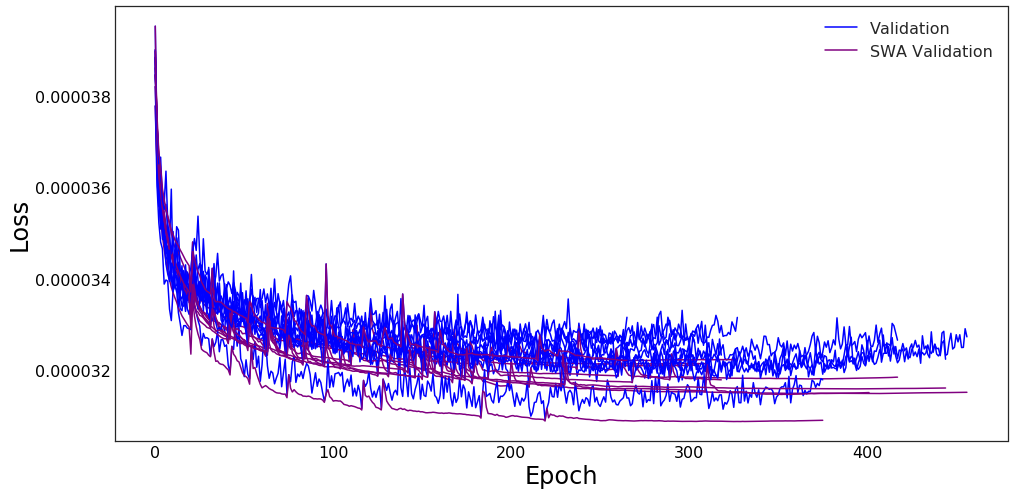

Mean loss = 3.18e-05 +- 1e-07
Mean wAUC = 0.0632 +- 0.0004
Mean AUC = 0.0985 +- 0.0007
______________________________________



<Figure size 432x288 with 0 Axes>

In [26]:
results, histories = _batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams, swaStart=1,
                                          patience=50, swaRenewal=5, sgdReplacement=True,
                                          trainOnWeights=True, cosAnnealMult=0, reduxDecay=False,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [21]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on val data

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [ ]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [ ]:
tPred = np.concatenate(pred, axis=1)

In [ ]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [ ]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [ ]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### Ref

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 4

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 10

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 16

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

In [ ]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Ref

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 6

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 3

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

# Final run

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

In [ ]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

## Response on validation data Rot-Ref 8 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
cut = amsScanQuick(convertToDF(valData.source))[1]

In [ ]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

In [ ]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

In [ ]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [ ]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

## Response on validation data Rot-Ref 16 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.95, 'Day_10_95_rotref16_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"